## Calculation of local fluorine fingerprints (LEF), random-forest-regression to predict $^\text{19}\text{F}$ CSA parameters $\delta_{\sigma}$ and $\eta$
S. Ruedisser, ETH-Zuerich 2025
---------------------------------------------------------------

In [1]:
# TODO
###################
# replace static CF3 averaging by dynamic CF3 averaging
# RF increase search space for CV

### Imports

In [2]:
from __future__ import print_function


import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from pprint import pprint
import time

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.AtomPairs import Pairs, Torsions
from rdkit.Chem import DataStructs

pd.options.mode.chained_assignment = None  # default='warn'

import multiprocessing

multiprocessing.cpu_count()
print("CPU available: " + str(len(os.sched_getaffinity(0))))

CPU available: 12


### Define functions

In [3]:
np.flip(np.sort([4, 2, 3]))

array([4, 3, 2])

In [4]:
def calculate_sigma_iso(row):
    """
    Calculates the isotropic shielding from the Eigenvalues of the CSA tensor.

    Args:
        row: Eigenvalues of the CSA tensor

    Returns:
        isotropic shielding
    """
    
    EValues = np.sort(row)
    sigma_iso = np.sum(EValues) / 3
    return np.real(sigma_iso)

def calculate_Delta_Sigma(row):
    """
    Calculates the anisotropy (Haeberlen-Mehring-Spiess notation) Delta from the Eigenvalues of the CSA tensor.

    Args:
        row: Eigenvalues of the CSA tensor

    Returns:
        anisotropy, Delta_sigma
    """
    
    EValues = np.sort(row)
    Delta_Sigma = EValues[2] - (EValues[1] + EValues[0]) / 2
    return np.real(Delta_Sigma)

def calculate_delta_sigma(row):
    """
    Calculates the anisotropy (solid-state NMR notation) from the Eigenvalues of the CSA tensor.

    Args:
        row: Eigenvalues of the CSA tensor

    Returns:
        anisotropy, delta_sigma
    """
    
    EValues = np.sort(row)
    delta_sigma = EValues[2] - (EValues[1] + EValues[0]) / 2
    return np.real(delta_sigma * 2 / 3)

def calculate_eta(row):
    """
    Calculates the asymmetry from the Eigenvalues of the CSA tensor.

    Args:
        row: Eigenvalues of the CSA tensor

    Returns:
        asymmetry, eta
    """
    
    EValues = np.sort(row)
    eta = (EValues[1] - EValues[0]) / (EValues[2] - calculate_sigma_iso(row)) 
    return np.real(eta)

def calculate_effective_DeltaSigma(row):
    """
    Calculates the effective anisotropy from the Eigenvalues of the CSA tensor.
    see Ruedisser et. al, 2025

    Args:
        row: Eigenvalues of the CSA tensor

    Returns:
        anisotropy, effective Delta_sigma
    """
    
    effective_DeltaSigma = calculate_delta_sigma(row) * np.sqrt(1 + calculate_eta(row)**2 / 3)
    return np.real(effective_DeltaSigma)


def maptonumpy(x):
    """
    Converts LEF fingerprint to numpy array.

    Args:
        x: LEF fingerprints, RDKit topological torsion fingerprints

    Returns:
        numpy array
    
    """
    
    arr = np.zeros(x.GetLength())
    DataStructs.ConvertToNumpyArray(x, arr)
    return arr
    
def calculate_averageCF3(row_list):
    """
    Returns the Eigenvalues of averaged tensor for CF3 groups.
    Averaging is performed by adding each components of the three tensors.
    The Eigenvalues of the resulting tensor are calculated
    
    The result is approximately correct since the three tensors are unequal.

    see Rüdisser et al., 2020

    Args:
        
    

    Returns:
    

    
    """
    tensor_average = np.array([[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]])
    
    for _row in row_list:
        tensor_average += np.array(_row)

    tensor_average /= 3

    Evalues = np.linalg.eigvals(tensor_average)
    return np.real(np.sort(Evalues))

def read_json(dir):
    """
    read *.json file with CF CSA values for all compounds in the directory dir
    gaussian output files (DFT) have been processed with the script DeltaSigmaCF3.py or csa_extractor.py provided in the gitlab repository
    https://gitlab.ethz.ch/ruedsimo/csar

    return Pandas DataFrame: cpd_code, CSA tensor for F1, F2, F3...

    works for CF and CF3  
    """

    directory = os.fsencode(dir)
    CSAall = pd.DataFrame(columns=["cpd_code"])
        
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith("_csa.json"): 
            dirfile = dir + filename
            CSA = pd.read_json(dirfile, orient="values", dtype=None)
            if CSA.empty:
                continue
            
            CSA.drop(index=[0,1], inplace=True)
            BNC_ID = filename.split("_")[0]
            CSA.index = [BNC_ID]
            for _i, _F in enumerate(CSA.columns):
                CSA.rename(columns={ _F: "F" + str(_i + 1) }, inplace = True)
                
            CSA["cpd_code"] = CSA.index
            CSAall = pd.concat([CSAall, CSA])     
            continue
        else:
            continue

    CSAall.reset_index(inplace=True, drop=True)
    
    return CSAall
     

In [5]:
########################################################
# local fluorine fingerprints
# https://github.com/rdkit/rdkit/tree/master/Contrib/LEF
#########################################################
# A. Vulpetti, U. Hommel, G. Landrum, R. Lewis and C. Dalvit, "Design and NMR-based screening of LEF,
# a library of chemical fragments with different Local Environment of Fluorine" J. Am. Chem. Soc. 131 (2009) 12949-12959. https://doi.org/10.1021/ja905207t
#########################################################
# A. Vulpetti, G. Landrum, S. Ruedisser, P. Erbel and C. Dalvit, "19F NMR Chemical Shift Prediction with 
# Fluorine Fingerprint Descriptor" J. of Fluorine Chemistry (2010). https://doi.org/10.1016/j.jfluchem.2009.12.024


def GetMolFingerprint(mol, maxPathLength):
  FQuery = Chem.MolFromSmarts('F')
  CF3Query = Chem.MolFromSmarts('[$(C(F)(F)F)]')
  CF3Rxn = AllChem.ReactionFromSmarts('[*:1]-C(F)(F)F>>[*:1]-F')
  hasCF3 = mol.HasSubstructMatch(CF3Query)
    
  if hasCF3:
    p = CF3Rxn.RunReactants((mol, ))[0][0]
    Chem.SanitizeMol(p)
    for nm in mol.GetPropNames():
      p.SetProp(nm, mol.GetProp(nm))
    mol = p
  match = mol.GetSubstructMatch(FQuery)
  fp = Torsions.GetHashedTopologicalTorsionFingerprint(mol, nBits=9192, targetSize=maxPathLength, fromAtoms=match)
  for i in range(2, maxPathLength):
    nfp = Torsions.GetHashedTopologicalTorsionFingerprint(mol, nBits=9192, targetSize=i, fromAtoms=match)
    for bit, v in nfp.GetNonzeroElements().items():#.iteritems():
      fp[bit] = fp[bit] + v
  return fp

### Read molecule information: compound code, SMILES, ...

In [6]:
# read in compound code (BNC number), SMILES, etc. for bioNMR platform compounds

bnsp = pd.read_excel("/home/Simon/Documents/BNSP/projects/FBS/doc/BNSP_Compounds_210119_v4-1.xlsx", header=1)
bnsp.drop(bnsp[bnsp["ID BNSP"].isna()].index, inplace=True)
bnsp["cpd_code"] = bnsp["ID BNSP"].str.split("-", expand=True)[1]
bnsp["cpd_code"] = bnsp["cpd_code"].astype(str)
TFL = bnsp[bnsp["ID BNSP"].str.contains("TFL")][["ID BNSP", "cpd_code", "Smiles", "Lab journal Chemist", "Comment"]]
FL = bnsp[bnsp["ID BNSP"].str.contains("BNC-FL")][["ID BNSP", "cpd_code", "Smiles", "Lab journal Chemist", "Comment"]]

In [7]:
bnsp.head()

,ID BNSP,Unnamed: 1,Barcode,Unnamed: 3,Smiles,Unnamed: 5,Unnamed: 6,RackNo,Rack_Pos_Matrix,Weight_eff,...,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Formula_eff,Formula,Unnamed: 26,Lab journal Chemist,Comment,cpd_code
0,BNC-HL0001-NS-1,DSI-01-A02,1.229856e+09,COC(=O)[C@@H]1C[C@@H](O)CN1C(=O)c2ccco2,COC(=O)[C@@H]1C[C@@H](O)CN1C(=O)c2ccco2,ENAMINE,Z1614545742,DSI-01,A02,239.22462,...,NaN,NaN,Single Enantiomer,98.0,C11H13NO5,C11H13NO5,"methyl (2S,4R)-1-(furan-2-carbonyl)-4-hydroxyp...",ENAMINE: Z1614545742,"methyl (2S,4R)-1-(furan-2-carbonyl)-4-hydroxyp...",HL0001
1,BNC-HL0002-NS-1,DSI-01-B02,1.229856e+09,CC(=O)Nc1ccc(NC(=O)[C@H]2CC2(C)C)cc1,CC(=O)Nc1ccc(NC(=O)[C@H]2CC2(C)C)cc1,ENAMINE,Z1505719304,DSI-01,B02,246.30492,...,NaN,NaN,Single Enantiomer,90.0,C14H18N2O2,C14H18N2O2,"(1S)-N-(4-acetamidophenyl)-2,2-dimethylcyclopr...",ENAMINE: Z1505719304,"(1S)-N-(4-acetamidophenyl)-2,2-dimethylcyclopr...",HL0002
2,BNC-HL0003-NS-1,DSI-01-C02,1.229856e+09,CCOc1ccc(NC(=O)NC(C)(C)C)cc1,CCOc1ccc(NC(=O)NC(C)(C)C)cc1,ENAMINE,Z44586802,DSI-01,C02,236.31010,...,NaN,NaN,Achiral,90.0,C13H20N2O2,C13H20N2O2,3-tert-butyl-1-(4-ethoxyphenyl)urea,ENAMINE: Z44586802,"3-tert-butyl-1-(4-ethoxyphenyl)urea, (ENAMINE:...",HL0003
3,BNC-HL0004-NS-1,DSI-01-D02,1.229856e+09,OCc1ccc(cc1)n2cnc3ccccc23,OCc1ccc(cc1)n2cnc3ccccc23,ENAMINE,Z235449082,DSI-01,D02,224.25788,...,NaN,NaN,Achiral,100.0,C14H12N2O,C14H12N2O,"[4-(1H-1,3-benzodiazol-1-yl)phenyl]methanol",ENAMINE: Z235449082,"[4-(1H-1,3-benzodiazol-1-yl)phenyl]methanol, (...",HL0004
4,BNC-HL0005-NS-1,DSI-01-E02,1.229856e+09,CCOC(=O)c1cc(no1)c2ccc(C)cc2,CCOC(=O)c1cc(no1)c2ccc(C)cc2,ENAMINE,Z793500562,DSI-01,E02,231.24722,...,NaN,NaN,Achiral,95.0,C13H13NO3,C13H13NO3,"ethyl 3-(4-methylphenyl)-1,2-oxazole-5-carboxy...",ENAMINE: Z793500562,"ethyl 3-(4-methylphenyl)-1,2-oxazole-5-carboxy...",HL0005


In [8]:
# read the json-file with eigenvectors and eigenvalues of the 19F CSA tensor for a molecule
# example for CF3, compound ID = TRY018

BNC_ID = "TRY018"
dir = "/home/Simon/Documents/BNSP/projects/19FNMR/gaussian/CF3library"
if  dir.endswith("/") == False:
    dir = dir + "/"
    
path = dir + BNC_ID + "_csa_CF3.json"
CSA = pd.read_json(path, orient="values", dtype=None)
CSA = pd.DataFrame(CSA.iloc[0]).transpose()
CSA.keys()
CSA["result"]

16F    [[169.638, 249.6601, 318.8666], [[0.8402700000...
Name: result, dtype: object

In [9]:
# read the json-file containing eigenvectors and eigenvalues of the 19F CSA tensor for a molecule
# example for CF3, compound ID = FL0771

BNC_ID = "FL0771"
dir = "/home/Simon/Documents/BNSP/projects/19FNMR/gaussian/CFlibrary"
if  dir.endswith("/") == False:
    dir = dir + "/"
    
path = dir + BNC_ID + "_csa.json"
CSA = pd.read_json(path, orient="values", dtype=None)
CSA.drop(index=[1,2], inplace=True)
CSA.index = [BNC_ID]
CSA

,16F
FL0771,"[241.6035, 268.5806, 383.6696]"


# Read CSA values from *.json files
The Eigenvalues and Eigenvectors are saved in a *.json file for each molecule
*.json files are in the CFlibrary or CF3library folder

In [10]:
########################################################################
# compute CSA parameters for CF
########################################################################

dir = "/home/Simon/Documents/BNSP/projects/19FNMR/gaussian/CFlibrary/"

CSAall = read_json(dir)

if len(CSAall.columns) == 2:
    
    CSAall["EValues"] = list(
        map(
            np.linalg.eigvals, CSAall["F1"]
            )
    )
    
    CSAall["sigma_iso"] = list(map(calculate_sigma_iso, CSAall["EValues"]))
    CSAall["Delta_Sigma"] = list(map(calculate_Delta_Sigma, CSAall["EValues"]))
    CSAall["eta"] = list(map(calculate_eta, CSAall["EValues"]))
    CSAall["delta_sigma"] = list(map(calculate_delta_sigma, CSAall["EValues"]))
    CSAall["effective_DeltaSigma"] = list(map(calculate_effective_DeltaSigma, CSAall["EValues"]))

    # Drop outliers

    CSAall.drop(CSAall[(CSAall["effective_DeltaSigma"] < 10.0)].index, inplace=True)
    CSAall.drop(CSAall[(CSAall["effective_DeltaSigma"] > 120.0)].index, inplace=True)

    print(dir)
    print("="*40)
    print("Average delta_sigma: " + str(CSAall["delta_sigma"].mean()))
    print("Average eta value: " + str(CSAall["eta"].mean()))
    print("Average Delta_sigma: " + str(CSAall["Delta_Sigma"].mean()))
    print("Average effective_Delta_sigma: " + str(CSAall["effective_DeltaSigma"].mean()))
    print("Total number of CSA values: " + str(CSAall.shape[0] - 1))
    print("-"*40)

    CSA_CF = CSAall.copy()

#########################################################################
# compute CSA parameters for CF3
#########################################################################

dir = "/home/Simon/Documents/BNSP/projects/19FNMR/gaussian/CF3library/"

CSAall = read_json(dir)


if len(CSAall.columns) > 3:

    CSAall["EValues"] = CSAall.apply(
        lambda row: calculate_averageCF3([row["F1"], row["F2"], row["F3"]]), 
        axis=1
    )
    
    CSAall["sigma_iso"] = list(map(calculate_sigma_iso, CSAall["EValues"]))
    CSAall["Delta_Sigma"] = list(map(calculate_Delta_Sigma, CSAall["EValues"]))
    CSAall["eta"] = list(map(calculate_eta, CSAall["EValues"]))
    CSAall["delta_sigma"] = list(map(calculate_delta_sigma, CSAall["EValues"]))
    CSAall["effective_DeltaSigma"] = CSAall["delta_sigma"] # eta = 0 for CF3
    #CSAall["effective_DeltaSigma"] = list(map(calculate_effective_DeltaSigma, CSAall["EValues"]))

    print(dir)
    print("="*40)
    print("Average delta_sigma: " + str(CSAall["delta_sigma"].mean()))
    print("Average eta value: " + str(CSAall["eta"].mean()))
    #print("Average Delta_sigma: " + str(CSAall["Delta_Sigma"].mean()))
    print("Average effective_Delta_sigma: " + str(CSAall["effective_DeltaSigma"].mean()))
    #print("Average effective_Delta_sigma: " + str(CSAall["effective_DeltaSigma"].mean()))
    print("Total number of CSA values: " + str(CSAall.shape[0] - 1))
    print("-"*40)

    CSA_CF3 = CSAall.copy()

/home/Simon/Documents/BNSP/projects/19FNMR/gaussian/CFlibrary/
Average delta_sigma: 71.4736165452357
Average eta value: 0.9966524580945121
Average Delta_sigma: 107.21042481785354
Average effective_Delta_sigma: 82.29136698793106
Total number of CSA values: 324
----------------------------------------
/home/Simon/Documents/BNSP/projects/19FNMR/gaussian/CF3library/
Average delta_sigma: 27.188970124449032
Average eta value: 2.2593249955967947
Average effective_Delta_sigma: 27.188970124449032
Total number of CSA values: 187
----------------------------------------


In [11]:
CSA_CF3.head(3)

,cpd_code,F1,F2,F3,F4,F5,EValues,sigma_iso,Delta_Sigma,eta,delta_sigma,effective_DeltaSigma
0,TFL251,"[[195.0959, 40.7743, -1.3286], [62.2891, 304.6...","[[205.7332, -34.3815, -71.3571], [-39.0022, 21...","[[206.0099, -41.6691, 56.5764], [-48.7477, 227...",NaN,NaN,"[200.0864037385524, 252.5721103320001, 262.527...",238.395478,36.198662,2.174902,24.132441,24.132441
1,TFL342,"[[284.6229, -56.7784, 9.0792], [-73.9763, 225....","[[173.8131, -7.8878, 28.1045], [3.6282, 281.02...","[[178.3906, -5.2758, -45.9901], [-0.7955, 249....",NaN,NaN,"[201.34416927024284, 263.01722077429406, 269.4...",244.601356,37.261982,2.482680,24.841321,24.841321
2,TFL338,"[[184.5368, -2.3722, -7.6254], [27.2481, 333.0...","[[216.7628, -33.0343, 47.3492], [-43.0538, 226...","[[238.2835, -30.6964, -61.0857], [-42.6972, 22...",NaN,NaN,"[204.9352926606135, 269.6963666849258, 288.826...",254.485922,51.510278,1.885869,34.340185,34.340185


In [12]:
CSA_CF.head(3)

,cpd_code,F1,EValues,sigma_iso,Delta_Sigma,eta,delta_sigma,effective_DeltaSigma
0,FL0771,"[[244.2902, 14.0891, -13.2646], [4.2986, 275.2...","[383.5739930768154, 242.47630809325983, 267.80...",297.951233,128.434140,0.295799,85.622760,86.862406
1,FL0008,"[[228.1623, -9.9405, 0.9154], [-10.9626, 275.7...","[225.92877008643518, 276.39548915977974, 367.2...",289.853233,116.073311,0.652175,77.382207,82.685968
2,FL0011,"[[286.9541, 55.8387, -18.1494], [59.4095, 269....","[219.83317884330103, 349.75923541615856, 299.7...",289.794133,89.947653,1.333389,59.965102,75.675913


In [13]:
# Alternativ input, if a csv file with the CSA is provided
# CF3: read in averaged Delta Sigma = sigma_yy - (sigma_xx + sigma_yy) / 2 from csv file
# for CF: use dataframe CSAall from above

if False:
    DS = pd.read_csv("/home/Simon/Documents/BNSP/projects/19FNMR/gaussian/CF3library/CF3_DeltaSigma.csv", header=None)
    DS.drop(columns=1, inplace=True)
    
    DS.rename(columns={0:"ID", 2:"DeltaSigma"}, inplace=True)
    DS["cpd_code"] = DS["ID"].str.split("_", expand=True)[0]
    DS["cpd_code"] = DS["cpd_code"].astype(str)
    
    # remove rows with missing DeltaSigma
    DS.drop(DS[(DS["DeltaSigma"] == " ")].index, inplace=True)
    
    DS["DeltaSigma"] = DS["DeltaSigma"].astype(float)
    
    # remove rows with "unreasonable" low or high DeltaSigma for CF3
    DS.drop(DS[(DS["DeltaSigma"] < 10.0)].index, inplace=True)
    DS.drop(DS[(DS["DeltaSigma"] > 90.0)].index, inplace=True)
    DS["DeltaSigma"].mean()*2/3
    
    DS.loc[DS["cpd_code"] == "TFL251"]

In [14]:
# merge dataframes with table containing SMILES

# CF3
CSA_CF3.rename(columns={"effective_DeltaSigma": "DeltaSigma"}, inplace=True)
CSA_CF3 = CSA_CF3[["cpd_code", "DeltaSigma"]]
TFL = TFL.merge(CSA_CF3, on="cpd_code", how="inner")

# CF
CSA_CF.rename(columns={"effective_DeltaSigma": "DeltaSigma"}, inplace=True)
CSA_CF = CSA_CF[["cpd_code", "DeltaSigma"]]
FL = FL.merge(CSA_CF, on="cpd_code", how="inner")

In [15]:
FL.head()

,ID BNSP,cpd_code,Smiles,Lab journal Chemist,Comment,DeltaSigma
0,BNC-FL0008-NS-1,FL0008,CC1=NOC(NCC=2C=CC(Cl)=C(F)C2)=N1,ENAMINE: Z1606822468,N-[(4-chloro-3-fluorophenyl)methyl]-3-methyl-1...,82.685968
1,BNC-FL0011-NS-1,FL0011,CCN1CC2=C(C(NC(=O)N2C)C=3C=CC=C(F)C3)C1=O,ENAMINE: Z1303983565,"6-ethyl-4-(3-fluorophenyl)-1-methyl-1H,2H,3H,4...",75.675913
2,BNC-FL0016-NS-1,FL0016,FC=1C=C(C#N)C=NC1NC2CC32CC3,ENAMINE: Z2409755645,5-fluoro-6-({spiro[2.2]pentan-1-yl}amino)pyrid...,68.587367
3,BNC-FL0019-NS-1,FL0019,CC=1C=CC(F)=C(C1)C(=O)NC2(CCSC2)C(=O)O,ENAMINE: Z1603648197,3-(2-fluoro-5-methylbenzamido)thiolane-3-carbo...,92.880642
4,BNC-FL0021-NS-1,FL0021,OCC1=CN=C2C=CC(F)=CN12,ENAMINE: Z2692095043,"{6-fluoroimidazo[1,2-a]pyridin-3-yl}methanol, ...",63.316033


In [16]:
TFL.head()

,ID BNSP,cpd_code,Smiles,Lab journal Chemist,Comment,DeltaSigma
0,BNC-TFL001-NS-1,TFL001,FC(F)(F)C1CCC(C(=O)NC2=NC=CS2)C(=O)N1,ENAMINE: Z358359792,"2-oxo-N-(1,3-thiazol-2-yl)-6-(trifluoromethyl)...",35.384201
1,BNC-TFL002-NS-1,TFL002,CC=1C=C(C)N2N=CC(C(=O)NCC(F)(F)F)=C2N1,ENAMINE: Z336830666,"5,7-dimethyl-N-(2,2,2-trifluoroethyl)pyrazolo[...",36.513973
2,BNC-TFL003-NS-1,TFL003,CC1=NN(C)C=C1C2=CSC(CC(F)(F)F)=N2,ENAMINE: Z1334514285,"4-(1,3-dimethyl-1H-pyrazol-4-yl)-2-(2,2,2-trif...",27.771827
3,BNC-TFL005-NS-1,TFL005,CNC(=O)N1CCCC(C1C)C(F)(F)F,ENAMINE: Z1728443064,"N,2-dimethyl-3-(trifluoromethyl)piperidine-1-c...",31.015428
4,BNC-TFL006-NS-1,TFL006,CC1(CC(F)(F)F)CN(C1)C(=O)C2CCNC2=O,ENAMINE: Z2641329313,"3-[3-methyl-3-(2,2,2-trifluoroethyl)azetidine-...",24.733716


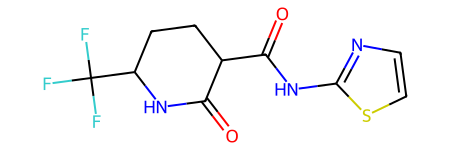

In [17]:
# Show structure of one example molecule
smiles = TFL[(TFL["cpd_code"] == "TFL001")]["Smiles"]
mol = Chem.MolFromSmiles(smiles.values[0])
mol

# CF

## Calculate LEF fingerprints

In [80]:
# for each row, calculate mol and LEF fingerprints with different path lengths up to max_path_lenth, convert to numpy array
# for CF and CF3 separately

max_path_length = 8

library = "FL" 
#library = "TFL" 

DS_LEF = FL.copy()
#DS_LEF = TFL.copy()

for i, row in DS_LEF.iterrows():
    DS_LEF.loc[i, "mol"] = Chem.MolFromSmiles(DS_LEF.loc[i, "Smiles"])
    
    for path_length in range(3, max_path_length + 1):   
        _col = "LEF" + str(path_length)
        _col_np = _col + "_np"
        DS_LEF.loc[i, _col] = GetMolFingerprint(DS_LEF.loc[i, "mol"], path_length) 

In [81]:
DS_LEF.head(2)

,ID BNSP,cpd_code,Smiles,Lab journal Chemist,Comment,DeltaSigma,mol,LEF3,LEF4,LEF5,LEF6,LEF7,LEF8
0,BNC-FL0008-NS-1,FL0008,CC1=NOC(NCC=2C=CC(Cl)=C(F)C2)=N1,ENAMINE: Z1606822468,N-[(4-chloro-3-fluorophenyl)methyl]-3-methyl-1...,82.685968,<rdkit.Chem.rdchem.Mol object at 0x7f7b2b0d6f80>,<rdkit.DataStructs.cDataStructs.LongSparseIntV...,<rdkit.DataStructs.cDataStructs.LongSparseIntV...,<rdkit.DataStructs.cDataStructs.LongSparseIntV...,<rdkit.DataStructs.cDataStructs.LongSparseIntV...,<rdkit.DataStructs.cDataStructs.LongSparseIntV...,<rdkit.DataStructs.cDataStructs.LongSparseIntV...
1,BNC-FL0011-NS-1,FL0011,CCN1CC2=C(C(NC(=O)N2C)C=3C=CC=C(F)C3)C1=O,ENAMINE: Z1303983565,"6-ethyl-4-(3-fluorophenyl)-1-methyl-1H,2H,3H,4...",75.675913,<rdkit.Chem.rdchem.Mol object at 0x7f7b2b3152a0>,<rdkit.DataStructs.cDataStructs.LongSparseIntV...,<rdkit.DataStructs.cDataStructs.LongSparseIntV...,<rdkit.DataStructs.cDataStructs.LongSparseIntV...,<rdkit.DataStructs.cDataStructs.LongSparseIntV...,<rdkit.DataStructs.cDataStructs.LongSparseIntV...,<rdkit.DataStructs.cDataStructs.LongSparseIntV...


## random-forest regression

In [21]:
# Enhanced parameter grid
param_grid = {
    'bootstrap': [True],
    'max_depth': [None, 50, 100],
    'max_features': ['sqrt', 0.5, 0.8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [100, 200, 300],
    'random_state': [42]  # For reproducibility
}

# Reduced parameter grid for testing
param_grid = {
    'bootstrap': [True],
    'criterion': ['squared_error'],
    'max_depth': [None, 50, 100],
    'max_features': [1, 2, 4],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 5, 10],
    #'n_estimators': [50, 70, 80]
    'n_estimators': [100, 200]
}

rf = RandomForestRegressor()
grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    cv=3, 
    n_jobs=-1, 
    verbose=1,  # Increased verbosity to monitor progress
    scoring='neg_mean_squared_error',  # Explicit scoring
    return_train_score=True
)

estimators = {}
results = {}

for maxL in range(3, max_path_length + 1):
    start_time = time.time()
    
    _col = "LEF" + str(maxL)
    x = np.array(list(map(maptonumpy, DS_LEF[_col])))  # Convert to numpy array
    y = np.array(DS_LEF["DeltaSigma"].tolist())
    
    grid_search.fit(x, y)
    best_estimator = grid_search.best_estimator_
    estimators[maxL] = best_estimator
    
    # Save model
    joblib.dump(best_estimator, f'{library}_rf_estimator_maxL_{maxL}.pkl')
    
    # Calculate additional metrics
    y_pred = best_estimator.predict(x)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    
    # Store results
    results[maxL] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'rmse': rmse,
        'r2': r2,
        'training_time': time.time() - start_time
    }
    
    print(f"max(L)= {maxL}:")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"CV score: {-grid_search.best_score_:.4f} (MSE)")
    print(f"Training RMSE: {rmse:.4f}")
    print(f"R² score: {r2:.4f}")
    print(f"Training time: {results[maxL]['training_time']:.2f}s")
    print("---------------------------------------------------------")

# Save all results
joblib.dump(results, f'{library}_training_results.pkl')

Fitting 3 folds for each of 162 candidates, totalling 486 fits
max(L)= 3:
Best parameters: {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 100, 'max_features': 1, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
CV score: 95.7264 (MSE)
Training RMSE: 9.2942
R² score: 0.2664
Training time: 282.07s
---------------------------------------------------------
Fitting 3 folds for each of 162 candidates, totalling 486 fits
max(L)= 4:
Best parameters: {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 100, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
CV score: 80.7560 (MSE)
Training RMSE: 7.5794
R² score: 0.5121
Training time: 102.39s
---------------------------------------------------------
Fitting 3 folds for each of 162 candidates, totalling 486 fits
max(L)= 5:
Best parameters: {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 50, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split

['FL_training_results.pkl']

## plot regression

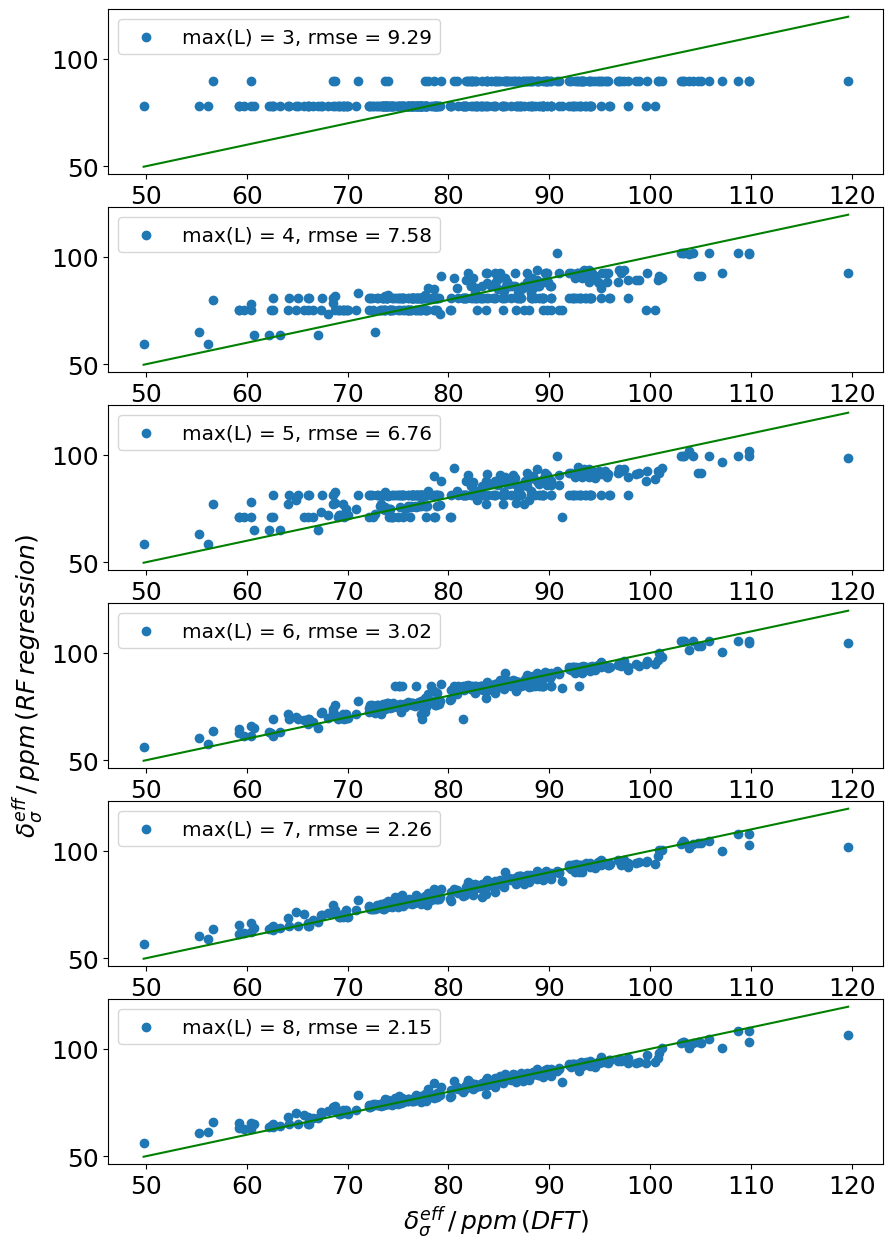

In [62]:
# Plot training results for either 
# FL or
# TFL library
# library = FL OR TFL

y = np.array(DS_LEF["DeltaSigma"].tolist())
library = "FL"


# Set plot parameters
params = {
    'legend.fontsize': 'x-large',
    'figure.figsize': (10, 15),
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18
}
plt.rcParams.update(params)

# Define data to plot
lef_data = {
    3: DS_LEF['LEF3'],
    4: DS_LEF['LEF4'],
    5: DS_LEF['LEF5'],
    6: DS_LEF['LEF6'],
    7: DS_LEF['LEF7'],
    8: DS_LEF['LEF8']
}

# Define number of subplots
n_subplots = len(lef_data)
fig, axs = plt.subplots(n_subplots)

# Convert LEF fingerprint to numpy array
x_mapped = {key: list(map(maptonumpy, value)) for key, value in lef_data.items()}

# Load training results
training_results = joblib.load(f'{library}_training_results.pkl')

# Plot data for each subplot
_min = np.min(y)
_max = np.max(y)

for i, maxL in enumerate(list(lef_data.keys())):
    # Load model and make predictions
    model = joblib.load(f'{library}_rf_estimator_maxL_{maxL}.pkl')
    predictions = model.predict(x_mapped[maxL])

    rmse = np.round(training_results[maxL]["rmse"], 2)
    
    # Create scatter plot
    axs[i].scatter(y, predictions, label=f"max(L) = {maxL}, rmse = {rmse}")
    
    # Add reference line
    axs[i].plot([_min, _max], [_min, _max], color="g")

    # Add legend
    axs[i].legend()

# Set labels
axs[int(n_subplots/2)].set(ylabel='$\delta_{\sigma}^{eff}\, /\, ppm\, (RF\, regression)$')
axs[n_subplots - 1].set(xlabel='$\delta_{\sigma}^{eff}\, /\, ppm\, (DFT)$')

# Print training results and save figure
fig.savefig(f'{library}_rf_maxL345678.svg')
fig.savefig(f'{library}_rf_maxL345678.png')

## plot single max(L)

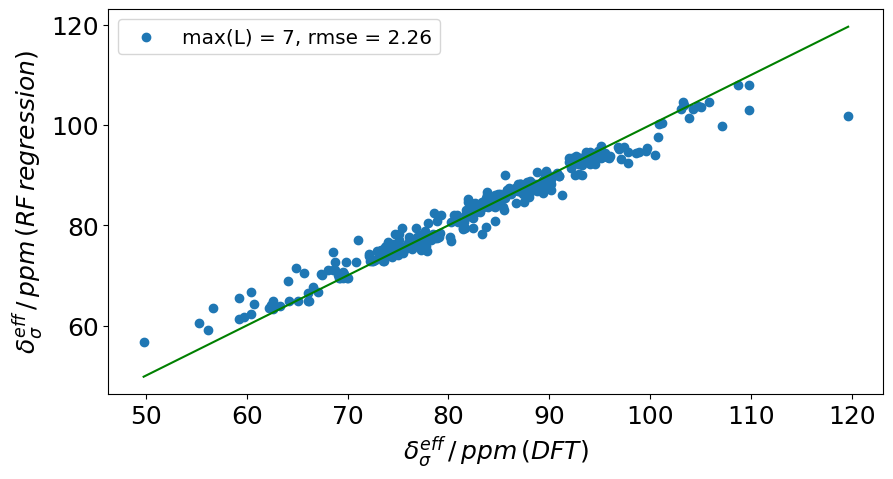

In [82]:
# Plot training results for either 
# FL or
# TFL library
# library = FL OR TFL

y = np.array(DS_LEF["DeltaSigma"].tolist())
library = "FL"


# Set plot parameters
params = {
    'legend.fontsize': 'x-large',
    'figure.figsize': (10, 5),
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18
}
plt.rcParams.update(params)

# Define data to plot
lef_data = {
    7: DS_LEF['LEF7']
}

# Define number of subplots

fig, axs = plt.subplots()

# Convert LEF fingerprint to numpy array
x_mapped = {key: list(map(maptonumpy, value)) for key, value in lef_data.items()}

# Load training results
training_results = joblib.load(f'{library}_training_results.pkl')

# Plot data for each subplot
_min = np.min(y)
_max = np.max(y)

maxL = 7
# Load model and make predictions
model = joblib.load(f'{library}_rf_estimator_maxL_{maxL}.pkl')
predictions = model.predict(x_mapped[maxL])

rmse = np.round(training_results[maxL]["rmse"], 2)

# Create scatter plot
axs.scatter(y, predictions, label=f"max(L) = {maxL}, rmse = {rmse}")

# Add reference line
axs.plot([_min, _max], [_min, _max], color="g")

# Add legend
axs.legend()

# Set labels
axs.set(ylabel='$\delta_{\sigma}^{eff}\, /\, ppm\, (RF\, regression)$')
axs.set(xlabel='$\delta_{\sigma}^{eff}\, /\, ppm\, (DFT)$')

# Print training results and save figure
fig.savefig(f'{library}_rf_maxL7.svg')


# CF3

## Calculate LEF fingerprints

In [83]:
# for each row, calculate mol and LEF fingerprints with different path lengths up to max_path_lenth, convert to numpy array
# for CF and CF3 separately

max_path_length = 8

#library = "TFL" 
library = "TFL" 

DS_LEF = TFL.copy()
#DS_LEF = TFL.copy()

for i, row in DS_LEF.iterrows():
    DS_LEF.loc[i, "mol"] = Chem.MolFromSmiles(DS_LEF.loc[i, "Smiles"])
    
    for path_length in range(3, max_path_length + 1):   
        _col = "LEF" + str(path_length)
        _col_np = _col + "_np"
        DS_LEF.loc[i, _col] = GetMolFingerprint(DS_LEF.loc[i, "mol"], path_length) 

In [84]:
DS_LEF.head(2)

,ID BNSP,cpd_code,Smiles,Lab journal Chemist,Comment,DeltaSigma,mol,LEF3,LEF4,LEF5,LEF6,LEF7,LEF8
0,BNC-TFL001-NS-1,TFL001,FC(F)(F)C1CCC(C(=O)NC2=NC=CS2)C(=O)N1,ENAMINE: Z358359792,"2-oxo-N-(1,3-thiazol-2-yl)-6-(trifluoromethyl)...",35.384201,<rdkit.Chem.rdchem.Mol object at 0x7f7b2ad88dd0>,<rdkit.DataStructs.cDataStructs.LongSparseIntV...,<rdkit.DataStructs.cDataStructs.LongSparseIntV...,<rdkit.DataStructs.cDataStructs.LongSparseIntV...,<rdkit.DataStructs.cDataStructs.LongSparseIntV...,<rdkit.DataStructs.cDataStructs.LongSparseIntV...,<rdkit.DataStructs.cDataStructs.LongSparseIntV...
1,BNC-TFL002-NS-1,TFL002,CC=1C=C(C)N2N=CC(C(=O)NCC(F)(F)F)=C2N1,ENAMINE: Z336830666,"5,7-dimethyl-N-(2,2,2-trifluoroethyl)pyrazolo[...",36.513973,<rdkit.Chem.rdchem.Mol object at 0x7f7b2ad892a0>,<rdkit.DataStructs.cDataStructs.LongSparseIntV...,<rdkit.DataStructs.cDataStructs.LongSparseIntV...,<rdkit.DataStructs.cDataStructs.LongSparseIntV...,<rdkit.DataStructs.cDataStructs.LongSparseIntV...,<rdkit.DataStructs.cDataStructs.LongSparseIntV...,<rdkit.DataStructs.cDataStructs.LongSparseIntV...


## random forest regression

In [30]:
# Enhanced parameter grid
param_grid = {
    'bootstrap': [True],
    'max_depth': [None, 50, 100],
    'max_features': ['sqrt', 0.5, 0.8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [100, 200, 300],
    'random_state': [42]  # For reproducibility
}

# Reduced parameter grid for testing
param_grid = {
    'bootstrap': [True],
    'criterion': ['squared_error'],
    'max_depth': [None, 50, 100],
    'max_features': [1, 2, 4],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 5, 10],
    #'n_estimators': [50, 70, 80]
    'n_estimators': [100, 200]
}

rf = RandomForestRegressor()
grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    cv=3, 
    n_jobs=-1, 
    verbose=1,  # Increased verbosity to monitor progress
    scoring='neg_mean_squared_error',  # Explicit scoring
    return_train_score=True
)

estimators = {}
results = {}

for maxL in range(3, max_path_length + 1):
    start_time = time.time()
    
    _col = "LEF" + str(maxL)
    x = np.array(list(map(maptonumpy, DS_LEF[_col])))  # Convert to numpy array
    y = np.array(DS_LEF["DeltaSigma"].tolist())
    
    grid_search.fit(x, y)
    best_estimator = grid_search.best_estimator_
    estimators[maxL] = best_estimator
    
    # Save model
    joblib.dump(best_estimator, f'{library}_rf_estimator_maxL_{maxL}.pkl')
    
    # Calculate additional metrics
    y_pred = best_estimator.predict(x)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    
    # Store results
    results[maxL] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'rmse': rmse,
        'r2': r2,
        'training_time': time.time() - start_time
    }
    
    print(f"max(L)= {maxL}:")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"CV score: {-grid_search.best_score_:.4f} (MSE)")
    print(f"Training RMSE: {rmse:.4f}")
    print(f"R² score: {r2:.4f}")
    print(f"Training time: {results[maxL]['training_time']:.2f}s")
    print("---------------------------------------------------------")

# Save all results
joblib.dump(results, f'{library}_training_results.pkl')

Fitting 3 folds for each of 162 candidates, totalling 486 fits
max(L)= 3:
Best parameters: {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 50, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
CV score: 16.9087 (MSE)
Training RMSE: 3.1494
R² score: 0.6483
Training time: 37.84s
---------------------------------------------------------
Fitting 3 folds for each of 162 candidates, totalling 486 fits
max(L)= 4:
Best parameters: {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 100, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
CV score: 12.3407 (MSE)
Training RMSE: 2.2770
R² score: 0.8161
Training time: 30.27s
---------------------------------------------------------
Fitting 3 folds for each of 162 candidates, totalling 486 fits
max(L)= 5:
Best parameters: {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 50, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 2

['TFL_training_results.pkl']

## plot regression

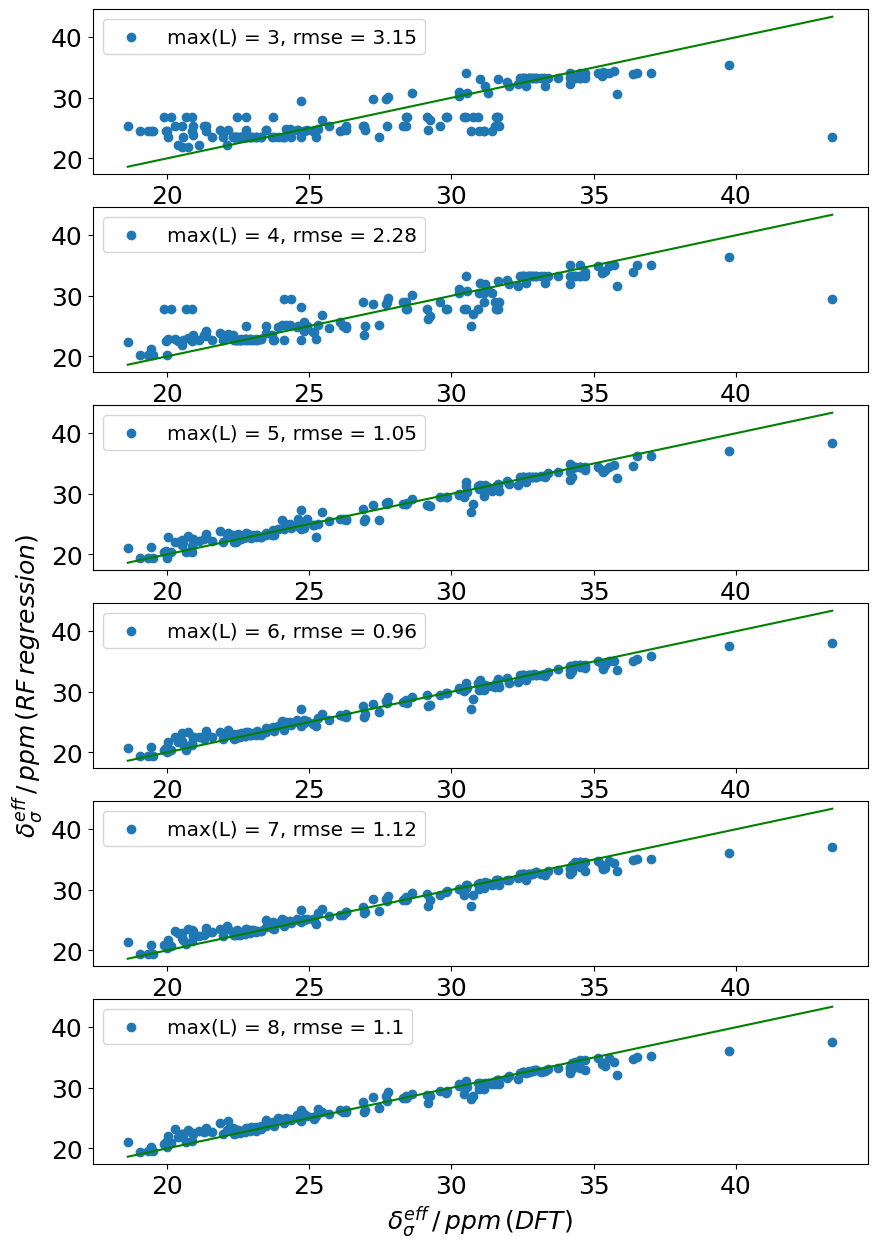

In [65]:
# Plot training results for either 
# FL or
# TFL library
# library = FL OR TFL

y = np.array(DS_LEF["DeltaSigma"].tolist())
library = "TFL"

# Set plot parameters
params = {
    'legend.fontsize': 'x-large',
    'figure.figsize': (10, 15),
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18
}
plt.rcParams.update(params)

# Define data to plot
lef_data = {
    3: DS_LEF['LEF3'],
    4: DS_LEF['LEF4'],
    5: DS_LEF['LEF5'],
    6: DS_LEF['LEF6'],
    7: DS_LEF['LEF7'],
    8: DS_LEF['LEF8']
}

# Define number of subplots
n_subplots = len(lef_data)
fig, axs = plt.subplots(n_subplots)

# Convert LEF fingerprint to numpy array
x_mapped = {key: list(map(maptonumpy, value)) for key, value in lef_data.items()}

# Load training results
training_results = joblib.load(f'{library}_training_results.pkl')

# Plot data for each subplot
_min = np.min(y)
_max = np.max(y)

for i, maxL in enumerate(list(lef_data.keys())):
    # Load model and make predictions
    model = joblib.load(f'{library}_rf_estimator_maxL_{maxL}.pkl')
    predictions = model.predict(x_mapped[maxL])

    rmse = np.round(results[maxL]["rmse"], 2)
    
    # Create scatter plot
    axs[i].scatter(y, predictions, label=f"max(L) = {maxL}, rmse = {rmse}")
    
    # Add reference line
    axs[i].plot([_min, _max], [_min, _max], color="g")

    # Add legend
    axs[i].legend()

# Set labels
axs[int(n_subplots/2)].set(ylabel='$\delta_{\sigma}^{eff}\, /\, ppm\, (RF\, regression)$')
axs[n_subplots - 1].set(xlabel='$\delta_{\sigma}^{eff}\, /\, ppm\, (DFT)$')

# Print training results and save figure
fig.savefig(f'{library}_rf_maxL345678.svg')
fig.savefig(f'{library}_rf_maxL345678.png')

## plot single max(L)

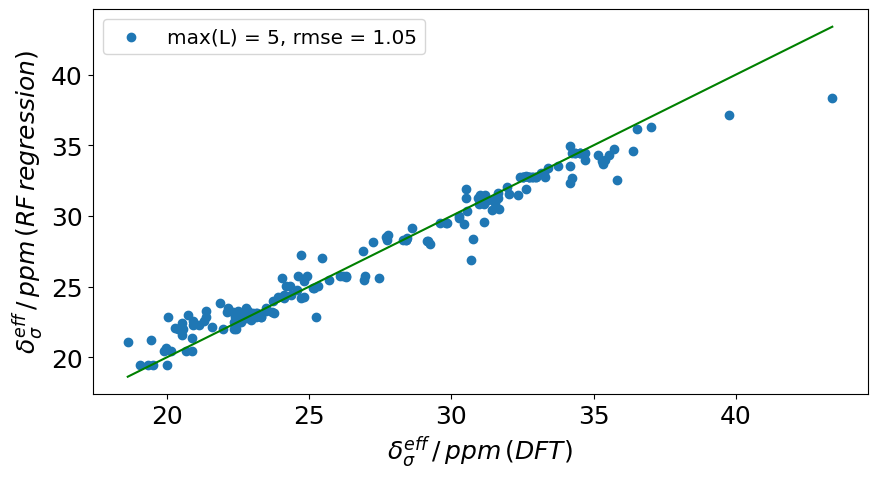

In [87]:
# Plot training results for either 
# FL or
# TFL library
# library = FL OR TFL

y = np.array(DS_LEF["DeltaSigma"].tolist())
library = "TFL"


# Set plot parameters
params = {
    'legend.fontsize': 'x-large',
    'figure.figsize': (10, 5),
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18
}
plt.rcParams.update(params)


# Define number of subplots

lef_data = {
    5: DS_LEF['LEF5']
}

fig, axs = plt.subplots()

# Convert LEF fingerprint to numpy array
x_mapped = {key: list(map(maptonumpy, value)) for key, value in lef_data.items()}

# Load training results
training_results = joblib.load(f'{library}_training_results.pkl')

# Plot data for each subplot
_min = np.min(y)
_max = np.max(y)

maxL = 5

# Load model and make predictions
model = joblib.load(f'{library}_rf_estimator_maxL_{maxL}.pkl')
predictions = model.predict(x_mapped[maxL])

rmse = np.round(training_results[maxL]["rmse"], 2)

# Create scatter plot
axs.scatter(y, predictions, label=f"max(L) = {maxL}, rmse = {rmse}")

# Add reference line
axs.plot([_min, _max], [_min, _max], color="g")

# Add legend
axs.legend()

# Set labels
axs.set(ylabel='$\delta_{\sigma}^{eff}\, /\, ppm\, (RF\, regression)$')
axs.set(xlabel='$\delta_{\sigma}^{eff}\, /\, ppm\, (DFT)$')

# Print training results and save figure
fig.savefig(f'{library}_rf_maxL{maxL}.svg')


# Appendix

In [ ]:
# perform grid search for different maxL

estimators = {}

for maxL in range(3, max_path_length + 1):
    #_col_np = "LEF" + str(maxL) + "_np"
    _col = "LEF" + str(maxL)
    x = list(map(maptonumpy, DS_LEF[_col]))
    y = DS_LEF["DeltaSigma"].tolist()
    
    grid_search.fit(x,y)
    
    estimators[maxL] = grid_search.best_estimator_
    
    grid_search.best_estimator_.fit(x,y)

    y_pred = best_estimator.predict(x)
    rmse = np.sqrt(mean_squared_error(y, y_pred))

    print("max(L)= " + str(maxL) + ": parameters: " + str(grid_search.best_estimator_.get_params()))
    print("max(L)= " + str(maxL) + ": best estimator RMSE: " + str(grid_search.best_estimator_.score(x,y)))
    print("---------------------------------------------------------")
 

# Save all estimators in one file
joblib.dump(estimators, 'FL_all_rf_estimators.pkl')